<a href="https://colab.research.google.com/github/MohamedBechir361/Optimisation-Projects/blob/main/GENETIC_ALGORITHM/SUPPLY_CHAIN_LOGISTICS_NETWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📦 Supply Chain Logistics Network Optimization : LP vs Genetic Algorithm

Supply chain logistics network problems have received significant attention among organizations due to their impact on cost efficiency and service performance. This notebook presents a model for a company operating multiple plants that serve geographically dispersed market zones. The goal is to allocate product demand across these plants while minimizing the total cost, which includes sourcing, manufacturing, and distribution.

---

## 🧠 Model Assumptions

1. **Single Product, Multi-Echelon System**  
   The supply chain includes multiple levels (plants → distributors → retailers) but focuses on a single product. We consider two stages for the numerical application.

2. **Deterministic Demand**  
   Demand at each market zone is known and remains constant throughout the study period.

3. **Unlimited Distributor Capacity**  
   Distributors are assumed to have no capacity constraints.

4. **Zero Transportation Lead Time**  
   Transportation time from plants to distributors and from distributors to retailers is considered negligible.

5. **Plant Capacity Constraint**  
   The total units sent to all distributors must not exceed the production capacity of the plants.

6. **Flow Conservation at Distributors**  
   All units entering a distributor must be dispatched—no inventory is held.

7. **Cost Parameters**  
   - Production cost per unit: 1.5 €
   - Distribution costs include transportation from plants to retailers and vice versa.

In [ ]:
!pip install gurobipy

In [ ]:
import random
import numpy as np
import pandas as pd
import gurobipy as gp
from scipy.optimize import linprog

In [ ]:
# Data
P = [0,1]
D = [0,1]
R = [0,1,2]

Cost = np.array([[0, 5],[4,2]])
Cost_dist = np.array([[3,4,5],[2,1,2]])
Demand = np.array([50000,100000,50000])
Capacity = np.array([150000,50000])
Prod_cost = 1.5

## LP Formulation

In [ ]:
IP_model = gp.Model()

# Defining Variables
X = IP_model.addVars(P, D, lb=0, vtype=gp.GRB.INTEGER, name="X")
Y = IP_model.addVars(D, R, lb=0, vtype=gp.GRB.INTEGER, name="Y")

# Model Constraints

# Demand Satisfaction
IP_model.addConstrs(gp.quicksum(Y[d,r] for d in D for r in R) >= Demand[r2] for r2 in R)

# Balance Equaton
IP_model.addConstrs(gp.quicksum(X[p,d] for p in P) == gp.quicksum(Y[d,r] for r in R) for d in D)

# Plant Capacity Constraint
IP_model.addConstrs(gp.quicksum(X[p,d] for d in D) <= Capacity[p] for p in P)

# Defining Objective : minimizing the total cost
Objective = gp.quicksum( (Cost[p,d]+ Prod_cost)*X[p,d] for p in P for d in D) + gp.quicksum(Cost_dist[d,r]*Y[d,r] for d in D for r in R)
IP_model.setObjective(Objective, gp.GRB.MINIMIZE)

# Solving the Model
IP_model.optimize()

NameError: name 'gp' is not defined

## Genetic Algorithm

In [ ]:
num_plants = len(P)
num_distributors = len(D)
num_retailers = len(R)

### Generation initial population

We begin by defining the structure of a chromosome, which encodes a feasible solution to the supply chain problem.

Each chromosome consists of two segments:

The first segment, of length num_plants × num_distributors, represents the quantity shipped from plant i to distributor j, while respecting the capacity constraints of each plant.

The second segment captures the quantity delivered from distributor j to retailer k, ensuring that each retailer's demand is satisfied.

A chromosome can be represented as a list of variables such as: ['X11', 'X12', 'X21', 'X22', 'Y11', 'Y12', 'Y21', 'Y22', 'Y31', 'Y32'] where Xij denotes flow from plant i to distributor j, and Yjk denotes flow from distributor j to retailer *k`.

We then randomly generate N candidate solutions to initialize the population.

In [ ]:
def random_split(Z, k):
    parts = np.random.rand(k)  # random numbers in [0,1)
    parts /= parts.sum()       # normalize so they sum to 1
    parts *= Z                 # scale so they sum to Z
    return parts

Z = 50000
k = 5
print(random_split(Z, k))
print("Sum =", random_split(Z, k).sum())

[ 8783.95112219 12992.33121923 12401.54338074 12165.43691342
  3656.73736442]
Sum = 50000.0


In [ ]:
def population_gen(n):
  # A genome is a list of constrained values for our variables
  # The first num_plants * num_distributors are reserved for the quantity produced and shipped to distributors
  # The population is a list of genomes

  pop = list()
  for i in range(n):
    # Generating the produced quantity by factory j, that will be divided on k distributors randomly
    genome1 = list()
    for j in range(num_plants) :
      Z1 = random.uniform(0,Capacity[j])
      k = num_distributors
      parts = random_split(Capacity[j], k)
      for x in parts.tolist():
        genome1.append(x)

    genome2 = list()
    for r in range(num_retailers):
      k = num_distributors
      parts = random_split(Demand[r], k)
      for x in parts.tolist():
        genome2.append(x)


    pop.append(genome1+genome2)

  return pd.DataFrame(pop, columns=['X11', 'X12', 'X21','X22', 'Y11', 'Y12', 'Y21', 'Y22','Y31','Y32'])



### Fitness function

To evaluate the quality of each chromosome in the population, we assess both its feasibility and its associated cost. A solution is considered feasible if it satisfies the demand constraint for each retailer — that is, the total quantity delivered to each retailer must be greater than or equal to their respective demand.

Due to the inherent randomness in the generation process, it is often impractical to match the exact demand values. Therefore, we adopt a relaxed feasibility criterion: a chromosome is deemed feasible as long as the delivered quantity exceeds the demand for every retailer.

For evaluating solution quality, we use the total cost of the supply chain network as the primary objective. However, to align with the principles of genetic algorithms — where higher fitness values indicate better solutions — we define the fitness function as the inverse of the total cost. To avoid numerical instability caused by very small fitness values, we scale the result by a factor of 100,000. Thus, the fitness function is defined as:


$
\text{fitness} =
\begin{cases}
\frac{100{,}000}{\text{total cost}}, & \text{if the solution is feasible} \\
0, & \text{otherwise}
\end{cases}$

This approach ensures that infeasible solutions are effectively penalized, while feasible solutions with lower costs are rewarded with higher fitness scores.

In [ ]:
def feasible(Y):

  if sum(Y[:4]) < sum(Y[4:]) :
      return False
  return True

def fitness(chromosome) :
  if not feasible(chromosome) :
    return 0

  total_cost = 0
  i = 0
  for p in range(num_plants):
    for d in range(num_distributors):
      total_cost += (Cost[p,d] + Prod_cost)*chromosome.iloc[i]
      i+=1

  for r in range(num_retailers):
    for d in range(num_distributors):
      total_cost += Cost_dist[d,r]*chromosome.iloc[i]
      i+=1

  return 100000/total_cost


### Selection of parents
Roulette wheel selection is a probabilistic method used in genetic algorithms to choose individuals for reproduction based on their fitness. Each individual is assigned a slice of a virtual roulette wheel proportional to its fitness value — the higher the fitness, the larger the slice. During selection, the wheel is "spun" and individuals are picked randomly, but with a bias toward those with better fitness. This approach ensures that stronger solutions have a higher chance of passing their genes to the next generation, while still allowing weaker ones a chance to contribute, preserving diversity in the population.

In [ ]:
def roulette_wheel_selection(df, num_selected):
    # Ensure fitness values are non-negative
    fitness = df['fitness'].clip(lower=0)

    # Handle the case where all fitness values are zero
    if fitness.sum() == 0:
        probs = np.ones(len(fitness)) / len(fitness)
    else:
        probs = fitness / fitness.sum()

    # Select indices based on fitness probabilities
    selected_indices = np.random.choice(df.index, size=num_selected, replace=False, p=probs)

    # Return the selected individuals
    return df.loc[selected_indices].reset_index(drop=True)


### Crossover

In [ ]:
def crossover(parent1, parent2):

    crossover_point = num_plants * num_distributors
    offspring1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    offspring2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))

    return offspring1, offspring2

In [ ]:
def perform_crossover(df, crossover_prob=0.8):
    offspring = []

    # Shuffle the selected population to make random pairs
    df = df.sample(frac=1).reset_index(drop=True)

    for i in range(0, len(df) - 1, 2):  # take pairs
        parent1 = df.iloc[i][:-1].values  # exclude fitness column
        parent2 = df.iloc[i + 1][:-1].values

        # Apply crossover based on crossover probability
        if np.random.rand() < crossover_prob:
            child1, child2 = crossover(parent1, parent2)
        else:
            # No crossover → children are clones
            child1, child2 = parent1, parent2

        offspring.append(child1)
        offspring.append(child2)

    offspring_df = pd.DataFrame(offspring, columns=df.columns[:-1])
    offspring_df['fitness'] = np.nan

    return offspring_df

### Mutation

In [ ]:
def mutation(table, mutation_prob):
    mutated_table = table[:]
    if random.random() <= mutation_prob:
        mutation_points = random.sample(range(len(table[0])), 2)
        for i in range(len(table)):
            mutated_table[i][mutation_points[0]], mutated_table[i][mutation_points[1]] = \
                mutated_table[i][mutation_points[1]], mutated_table[i][mutation_points[0]]
    return mutated_table


### Full GA algorithm

In [ ]:
N = 1000
maxIter = 200
i=0

print("---------- Initiation of the initial population--------------")
population = population_gen(N)

print("---------- Initiation of the initial fitness--------------")
fitness_evaluaton = list()
for index, row in population.iterrows():
  fitness_evaluaton.append(fitness(row))

population['fitness'] = fitness_evaluaton

#print(population.nlargest(N, 'fitness').head())

---------- Initiation of the initial population--------------
---------- Initiation of the initial fitness--------------


/tmp/ipython-input-1120482389.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cost += (Cost[p,d] + Prod_cost)*chromosome[i]
/tmp/ipython-input-1120482389.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cost += Cost_dist[d,r]*chromosome[i]


In [ ]:
print("---------- Starting Iterations--------------")
best = population.nlargest(1, 'fitness')
while maxIter > i:
  i+=1

  # Select parents to create the new generation
  selected_parents = roulette_wheel_selection(population, int(N/2))
  offspring = perform_crossover(selected_parents)

  fitness_evaluaton_offsprings = list()
  for index, row in offspring.iterrows():
    fitness_evaluaton_offsprings.append(fitness(row))

  offspring['fitness'] = fitness_evaluaton_offsprings

  new_population = pd.concat([selected_parents, offspring], ignore_index=True)
  population = new_population.nlargest(N, 'fitness')
  best = population.nlargest(1, 'fitness')

population.head()

---------- Starting Iterations--------------


/tmp/ipython-input-1120482389.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cost += (Cost[p,d] + Prod_cost)*chromosome[i]
/tmp/ipython-input-1120482389.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cost += Cost_dist[d,r]*chromosome[i]
/tmp/ipython-input-1120482389.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_cost += (Cost[p,d] + Prod_cost)*chromosome[i]
/tmp/ipython-input-1120482389.py:25: Fut

,X11,X12,X21,X22,Y11,Y12,Y21,Y22,Y31,Y32,fitness
216,142393.395409,7606.604591,14518.297932,35481.702068,12126.241333,37873.758667,9161.515817,90838.484183,10131.520089,39868.479911,0.119464
529,142393.395409,7606.604591,14518.297932,35481.702068,12126.241333,37873.758667,9161.515817,90838.484183,10131.520089,39868.479911,0.119464
197,142393.395409,7606.604591,14518.297932,35481.702068,12126.241333,37873.758667,9161.515817,90838.484183,10131.520089,39868.479911,0.119464
890,142393.395409,7606.604591,14518.297932,35481.702068,12126.241333,37873.758667,9161.515817,90838.484183,10131.520089,39868.479911,0.119464
886,142393.395409,7606.604591,14518.297932,35481.702068,12126.241333,37873.758667,9161.515817,90838.484183,10131.520089,39868.479911,0.119464


In [ ]:
#population.head(10)
print(100000/best['fitness'])
print(best)

216    837074.967868
Name: fitness, dtype: float64
               X11          X12           X21           X22           Y11  \
216  142393.395409  7606.604591  14518.297932  35481.702068  12126.241333   

              Y12          Y21           Y22           Y31           Y32  \
216  37873.758667  9161.515817  90838.484183  10131.520089  39868.479911   

      fitness  
216  0.119464  


### Analysing the Impact of Population Size on Solution Quality

Increasing the population size in a genetic algorithm generally leads to improved solution quality. A larger population provides greater diversity among candidate solutions, which enhances the algorithm's ability to explore the search space and avoid premature convergence to suboptimal solutions.

With more individuals, the algorithm has a higher chance of discovering better-performing chromosomes, especially in complex or highly constrained problems like supply chain optimization. However, it's important to balance population size with computational cost, as larger populations require more processing time per generation.

In [ ]:
maxIter = 200
solutions = dict()
for N in [200, 500, 1000, 1500, 2000] :
  i=0
  print("---------- Starting Iterations for N =", N, "--------------")

  population = population_gen(N)

  print("---------- Initiation of the initial fitness--------------")
  fitness_evaluaton = list()
  for index, row in population.iterrows():
    fitness_evaluaton.append(fitness(row))

  population['fitness'] = fitness_evaluaton

  print("---------- Starting Iterations--------------")

  best = population.nlargest(1, 'fitness')

  while maxIter > i:
    i+=1

    # Select parents to create the new generation
    selected_parents = roulette_wheel_selection(population, int(N/2))
    offspring = perform_crossover(selected_parents)

    fitness_evaluaton_offsprings = list()
    for index, row in offspring.iterrows():
      fitness_evaluaton_offsprings.append(fitness(row))

    offspring['fitness'] = fitness_evaluaton_offsprings

    new_population = pd.concat([selected_parents, offspring], ignore_index=True)
    population = new_population.nlargest(N, 'fitness')
    best = population.nlargest(1, 'fitness')
    solutions[N] = 100000/best['fitness']


---------- Starting Iterations for N = 200 --------------
---------- Initiation of the initial fitness--------------
---------- Starting Iterations--------------


/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will ra

---------- Starting Iterations for N = 500 --------------
---------- Initiation of the initial fitness--------------
---------- Starting Iterations--------------


/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will ra

---------- Starting Iterations for N = 1000 --------------
---------- Initiation of the initial fitness--------------
---------- Starting Iterations--------------


/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will ra

---------- Starting Iterations for N = 1500 --------------
---------- Initiation of the initial fitness--------------
---------- Starting Iterations--------------


/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will ra

---------- Starting Iterations for N = 2000 --------------
---------- Initiation of the initial fitness--------------
---------- Starting Iterations--------------


/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  solutions[N] = int(100000/best['fitness'])
/tmp/ipython-input-1236969016.py:38: FutureWarning: Calling int on a single element Series is deprecated and will ra

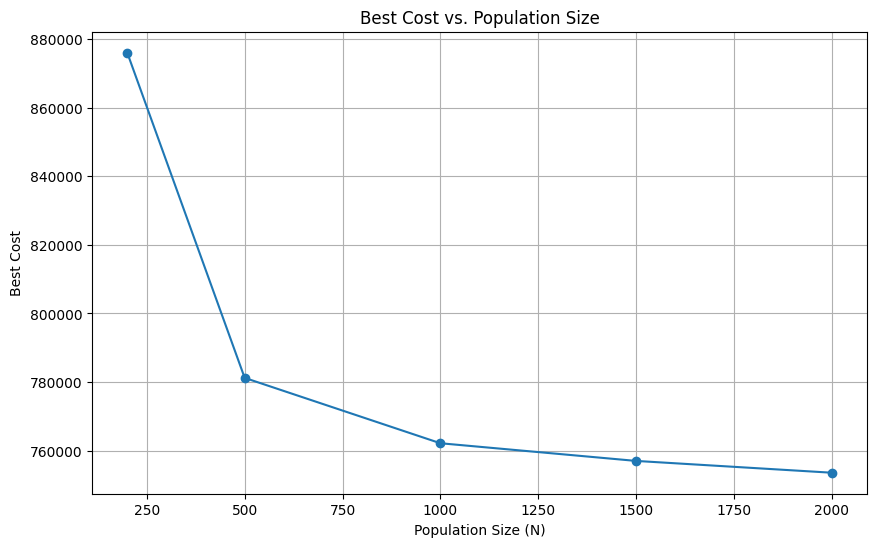

In [ ]:
import matplotlib.pyplot as plt

# Sort the dictionary by keys (population size) for proper plotting
sorted_solutions = dict(sorted(solutions.items()))

# Extract population sizes and costs
population_sizes = list(sorted_solutions.keys())
costs = list(sorted_solutions.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(population_sizes, costs, marker='o', linestyle='-')
plt.xlabel('Population Size (N)')
plt.ylabel('Best Cost')
plt.title('Best Cost vs. Population Size')
plt.grid(True)
plt.show()